<a href="https://colab.research.google.com/github/chuuxter/MODELOS-DE-CLASIFICACION/blob/main/Algoritmo_de_clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# En una celda de Colab ejecuta:
!git config --global user.email "aldairramirez13@hotmail.com"
!git config --global user.name "chuuxter"

In [ ]:
#LIBRERIAS NECESARIAS PARA LOS ALGORITMOS
!pip install pandas numpy scikit-learn nltk matplotlib seaborn jupyter

In [ ]:
import pandas as pd # LIBRERIA PARA MANIPULACION DE DATOS
import numpy as np # LIBRERIA PARA CALCULOS MATEMATICOS Y ARREGLOS
import nltk # NATURAL LANGUAGE TOOLKIT PARA PROCESAMIENTO
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from nltk.corpus import wordnet as wn # ANLISIS SEMANTICO Y DE SINONIMOS
from sklearn.model_selection import train_test_split # DIVISION DE DATOS EN ENTRENAMIENTO Y PRUEBAS
from sklearn.ensemble import RandomForestClassifier # CLASIFICADOR RANDOM FOREST
from sklearn.metrics import accuracy_score, classification_report #M METRICAS PARA PRECISION DEL MODELO
from sklearn.linear_model import LogisticRegression # REGRESION LOGISTICA PARA CLASIFICACION
from sklearn.svm import SVC # MAQUINAS DE VECTORES DE SOPORTE PARA CLASIFICACION
from sklearn.neighbors import KNeighborsClassifier #IMPORTAR KVECINOS MAS CERCANOS
from sklearn.naive_bayes import GaussianNB #IMPORTAR NAIVE BAYES PARA CLASIFICACINO PROBABILISTICA
from sklearn.preprocessing import LabelEncoder


# Descargar datos para NLTK
nltk.download('wordnet')
nltk.download('omw-1.4')

print("Todo instalado y listo!")


In [ ]:
from google.colab import files
uploaded = files.upload()

In [5]:
# CARGA DE DATOS DEL DATASET
students = pd.read_csv('studentInfo.csv')
vle = pd.read_csv('vle.csv')
student_vle = pd.read_csv('studentVle.csv')

print("Dimensiones de los datasets:")
print(f"Estudiantes: {students.shape}")
print(f"Actividades VLE: {vle.shape}")
print(f"Interacciones: {student_vle.shape}")

print("\nPrimeras filas de studentInfo:")
students.head()

Dimensiones de los datasets:
Estudiantes: (32593, 12)
Actividades VLE: (6364, 6)
Interacciones: (10655280, 6)

Primeras filas de studentInfo:


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [6]:
# FILTRAR ESTUDIANTES QUE NO ABANDONARON EL CURSOS
active_students = students[students['final_result'] != 'Withdrawn']
active_student_ids = active_students['id_student']

# FILTRAR LAS ACTIVIDADES DE LOS ESTUDIANTES ACTIVOS
active_interactions = student_vle[student_vle['id_student'].isin(active_student_ids)]

print(f"Estudiantes activos: {len(active_students)}")
print(f"Interacciones de activos: {len(active_interactions)}")

Estudiantes activos: 22437
Interacciones de activos: 9921259


In [7]:
# DICCIONARIO PARA VARK, INCLUYE CATEGORIA LECTURA/ESCRITURA
activity_type_to_vark = {
    # VISUAL
    'resource': 'visual',
    'page': 'visual',
    'url': 'visual',
    'htmlactivity': 'visual',
    # AUDITIVO
    'forumng': 'auditory',
    'ouaudio': 'auditory',
    'ouelluminate': 'auditory',
    # LECTURA ESCRITURA
    'glossary': 'readwrite',
    'ouwiki': 'readwrite',
    'dataplus': 'readwrite',
    'questionnaire': 'readwrite',
    'subpage': 'readwrite',
    # KINESTESICO
    'quiz': 'kinesthetic',
    'oucollaborate': 'kinesthetic',
    'homepage': 'kinesthetic',
    'externalquiz': 'kinesthetic',
    'dualpane': 'kinesthetic'
}

# SE APLICA EL MAPEO
vle['vark_style'] = vle['activity_type'].map(activity_type_to_vark)

# MOSTRAR EL RESULTADO DEL MAPEO
print("Distribución de actividades por estilo VARK:")
print(vle['vark_style'].value_counts())

Distribución de actividades por estilo VARK:
vark_style
visual         3652
readwrite      1214
kinesthetic     277
auditory        215
Name: count, dtype: int64


In [8]:
# RELACIONAR INTERACCIONES DE LA PLATAFORMA CON ESTILOS VARK
vle_enriched = active_interactions.merge(
    vle[['id_site', 'code_module', 'code_presentation', 'vark_style']],
    on=['id_site', 'code_module', 'code_presentation']
)

# CREAR TABLA DE CARACTERISTICAS DE ESTUDIANTES
student_vark_totals = vle_enriched.groupby(['id_student', 'vark_style'])['sum_click'].sum().reset_index()

# PIVOTAR ESTILOS EN UNA COLUMNA
features_df = student_vark_totals.pivot_table(
    index='id_student',
    columns='vark_style',
    values='sum_click',
    fill_value=0
).reset_index()

# VERIFICAR LA COLUNNA
vark_styles = ['visual', 'auditory', 'readwrite', 'kinesthetic']
for style in vark_styles:
    if style not in features_df.columns:
        features_df[style] = 0

print("Tabla de características creada!")
features_df.head()

Tabla de características creada!


vark_style,id_student,auditory,kinesthetic,readwrite,visual
0,6516,451.0,497.0,164.0,174.0
1,11391,193.0,138.0,32.0,18.0
2,23629,87.0,67.0,5.0,2.0
3,23698,63.0,697.0,98.0,48.0
4,23798,145.0,276.0,48.0,77.0


 Distribución de estilos dominantes:
dominant_style
kinesthetic    15261
auditory        3992
readwrite       1371
visual           164
Name: count, dtype: int64


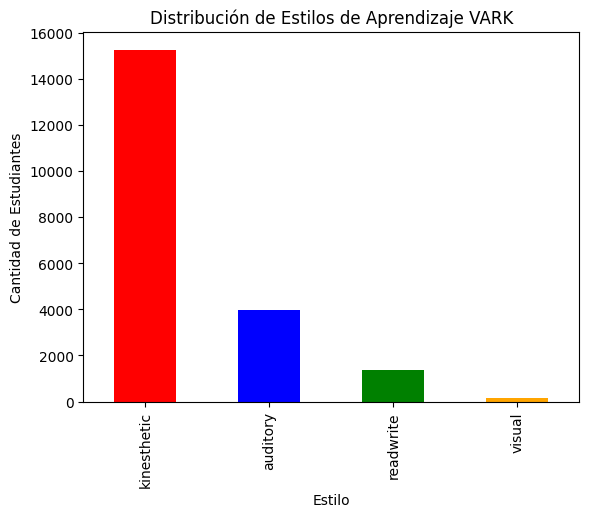

In [9]:
# DETERMINAR ESTILO DOMINANTE DE CADA ESTUDIANTE
features_df['dominant_style'] = features_df[vark_styles].idxmax(axis=1)

print(" Distribución de estilos dominantes:")
print(features_df['dominant_style'].value_counts())

# VISUALIZAR
import matplotlib.pyplot as plt
features_df['dominant_style'].value_counts().plot(kind='bar', color=['red', 'blue', 'green', 'orange'])
plt.title('Distribución de Estilos de Aprendizaje VARK')
plt.xlabel('Estilo')
plt.ylabel('Cantidad de Estudiantes')
plt.show()

In [10]:
# 1. DEFINIR FEATURES X Y
X = features_df[['visual', 'auditory', 'readwrite', 'kinesthetic']]  # Las 4 columnas de estilos
y = features_df['dominant_style']  # La columna con el estilo dominante

# 2. CONVERTIR ETIQUETAS (0, 1, 2, 3)
le = LabelEncoder()
y_encoded = le.fit_transform(y)  #Y SE CONVIERTE EN NUMERO: 0, 1, 2, 3

# 3. DIVIDIR ENTRAMIENTO (80%) y PRUEBA (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print("\n Ejemplo de features OULAD (primer estudiante):")
print(X_train.iloc[0])
print(f"Estilo real: {y_train[0]} → {le.inverse_transform([y_train[0]])[0]}")

print("\n Datos preparados para ML:")
print(f"   X_train: {X_train.shape}")
print(f"   X_test:  {X_test.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   y_test:  {y_test.shape}")
print("\n Distribución de clases en y_train:")
print(pd.Series(y_train).value_counts())


 Ejemplo de features OULAD (primer estudiante):
vark_style
visual          64.0
auditory         5.0
readwrite       45.0
kinesthetic    497.0
Name: 5225, dtype: float64
Estilo real: 1 → kinesthetic

 Datos preparados para ML:
   X_train: (16630, 4)
   X_test:  (4158, 4)
   y_train: (16630,)
   y_test:  (4158,)

 Distribución de clases en y_train:
1    12167
0     3233
2     1094
3      136
Name: count, dtype: int64



 Entrenando y comparando algoritmos...
Random Forest        -> Accuracy: 98.41%
SVM                  -> Accuracy: 95.36%
K-NN                 -> Accuracy: 98.10%
Logistic Regression  -> Accuracy: 99.98%
XGBoost              -> Accuracy: 98.27%

 TABLA COMPARATIVA FINAL
             Algorithm  Accuracy
3  Logistic Regression  0.999759
0        Random Forest  0.984127
4              XGBoost  0.982684
2                 K-NN  0.981000
1                  SVM  0.953583


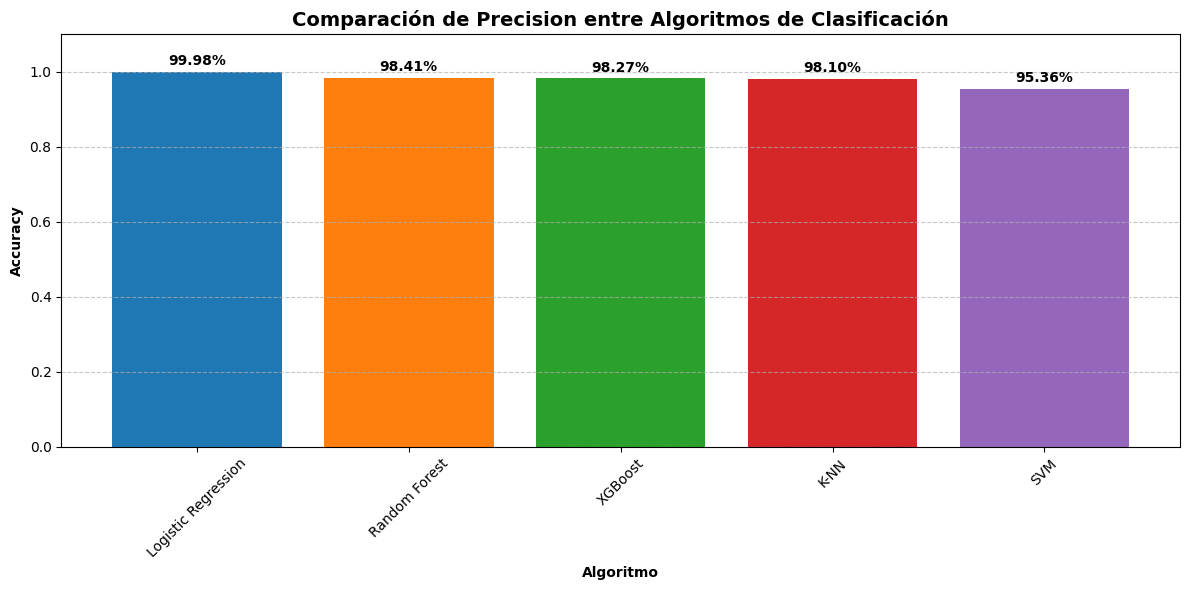


 LOS 3 MEJORES ALGORITMOS:
4. Logistic Regression: 99.98%
1. Random Forest: 98.41%
5. XGBoost: 98.27%

 REPORTE DE CLASIFICACIÓN - Logistic Regression:
              precision    recall  f1-score   support

    auditory       1.00      1.00      1.00       759
 kinesthetic       1.00      1.00      1.00      3094
   readwrite       1.00      1.00      1.00       277
      visual       0.97      1.00      0.98        28

    accuracy                           1.00      4158
   macro avg       0.99      1.00      1.00      4158
weighted avg       1.00      1.00      1.00      4158



In [12]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42),
    'K-NN': KNeighborsClassifier(n_neighbors=5),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss')
}

# ALMACENAR RESULTAODS
results = []

print("\n Entrenando y comparando algoritmos...")
print("="*50)


for name, model in models.items():
    # ENTRENAR
    model.fit(X_train, y_train)
    # PREDECIR
    y_pred = model.predict(X_test)
    # ACCURACY
    acc = accuracy_score(y_test, y_pred)
    # GUARDAR RESULTADOS
    results.append({'Algorithm': name, 'Accuracy': acc})
    # MOSTRAR RESULTADOS
    print(f'{name:20} -> Accuracy: {acc:.2%}')

# DATAFRAME PARA RESULTADOS
results_df = pd.DataFrame(results).sort_values('Accuracy', ascending=False)

# Mostrar tabla comparativa
print("\n" + "="*50)
print(" TABLA COMPARATIVA FINAL")
print("="*50)
print(results_df)

# TABLA COMPARATIVA
plt.figure(figsize=(12, 6))
bars = plt.bar(results_df['Algorithm'], results_df['Accuracy'],
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

# VALORES DE ACCIRACY
for bar, acc in zip(bars, results_df['Accuracy']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.2%}', ha='center', va='bottom', fontweight='bold')

plt.title('Comparación de Precision entre Algoritmos de Clasificación', fontsize=14, fontweight='bold')
plt.xlabel('Algoritmo', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.ylim(0, 1.1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3 MEJORES MODELOS
print("\n LOS 3 MEJORES ALGORITMOS:")
print("="*30)
for i, row in results_df.head(3).iterrows():
    print(f"{i+1}. {row['Algorithm']}: {row['Accuracy']:.2%}")

# ==================  REPORTE DE CLASIFICACIÓN DEL MEJOR MODELO ==================
# ENTRENAR EL MEJOR MODELO PARA TENER RESULTADO MAS PRECISO
best_model_name = results_df.iloc[0]['Algorithm']
best_model = models[best_model_name]
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print(f"\n REPORTE DE CLASIFICACIÓN - {best_model_name}:")
print("="*50)
print(classification_report(y_test, y_pred, target_names=le.classes_))